In [3]:
# Goal: Estimate the electron density at keck_late epoch
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

In [8]:
# TODO: move those models to a common model package
MODEL_PREFIX = 'oxygen_tau_'
#MODELS = {
#    'full_multiline_nlte0.1': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
#    'full_multiline_nlte0.1_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True),
#    'full_multiline_nlte0.1_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False),
#    'full_multiline_nlte0.1_mz_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True, multizone_reverse_tau_max_ratio=0.4),
#    'full_multiline_nlte0.1_mz_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_thick_shell_enable=True),
#    'full_multiline_nlte0.01': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
#    'full_multiline_nlte0.01_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6240]),
    #'full_multiline_nlte0.05': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.05,  max_extra_line_amp=3e-14),
#    'full_multiline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
#    'full_snglline_nlte0.01': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
#    'full_snglline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    #'full_line6230_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([6230]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14)

#}

sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}

SAMPLER_PARAMS = {
    'nlive_points': 5000,
    'dynesty_method': 'rwalk',
    'dynesty_pfrac': 0.2
}

def make_model(model, spec_name, no_cache=False):
    cfg = MODELS[model]
    spec, overrides = SPECS[spec_name]
    spec = spec[~np.isnan(spec['flux'])]
    params = cfg._replace(**overrides)
    
    model_name = MODEL_PREFIX + model + '_' + spec_name
    if no_cache:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS, cache_options=set(['ignore-cache']))
    else:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS)

def spec_name_to_label(specn):
    if specn == 'not_late':
        return '+128d'
    elif specn == 'keck_early':
        return '+138d'
    elif specn == 'keck_late':
        return '+349d'
    else:
        return ''
    
def extract_trace(specmod, idx, tidx=None):
    specmod.run()
    trace = specmod.samples
    if tidx is None:
        return trace[:,idx]
    else:
        return trace[tidx,idx]

extract_model_moi = functools.partial(extract_trace, idx=0)
extract_model_temp = functools.partial(extract_trace, idx=1)
extract_model_line_width = functools.partial(extract_trace, idx=2)
extract_model_optical_depth6300 = functools.partial(extract_trace, idx=9)


def extract_model_line_velocity(specmod, tidx):
    width = extract_model_line_width(specmod, tidx=tidx)
    velocity_sigma = width/6300 * 299792.458
    return 2*np.sqrt(np.log(2)) * velocity_sigma

In [5]:
# TODO: move those models to a common model package
MODEL_PREFIX = 'oxygen_tau_'
MODELS = {
    'full_multiline_nlte0.1': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.7': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.7,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.1_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True),
    'full_multiline_nlte0.1_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False),
    'full_multiline_nlte0.1_mz_jet': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6170, 6230], multizone_max_width=23, multizone_reverse_tau_enable=True, multizone_blue_wing_enable=True, multizone_reverse_tau_max_ratio=0.4),
    'full_multiline_nlte0.1_mz_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6540, extra_lines=np.array([5500, 6190, 6230]), max_width=29, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6190, 6230], multizone_max_width=30, multizone_thick_shell=np.array([6190, 6230])),
    'full_multiline_nlte0.1_mz_outer_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6540, extra_lines=np.array([5500, 6180, 6230]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=300e-14, multizone_lines=[6190, 6240], multizone_max_width=30, multizone_thick_shell=np.array([6190])),
    'full_multiline_nlte0.01': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.01_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6170, 6240]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.01,  max_extra_line_amp=3e-14, multizone_lines=[6170, 6240]),
    #'full_multiline_nlte0.05': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.05,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    'full_twoline_nlte0.1_mz': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6230], multizone_max_width=23, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False),
    'full_twoline_nlte0.1_mz_shell': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6050, stop6300_6364=6560, extra_lines=np.array([5500, 6230]), max_width=33, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14, multizone_lines=[6230], multizone_max_width=30, multizone_reverse_tau_enable=False, multizone_blue_wing_enable=False, multizone_thick_shell=np.array([6230])),
    'full_snglline_nlte0.1': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.7': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=28, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.7,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.95': oxygen.make_setup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    #'full_line6230_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([6230]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14)

}

sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}

SAMPLER_PARAMS = {
    'nlive_points': 5000,
    'dynesty_method': 'rwalk',
    'dynesty_pfrac': 0.2
}

def make_model(model, spec_name, no_cache=False):
    cfg = MODELS[model]
    spec, overrides = SPECS[spec_name]
    spec = spec[~np.isnan(spec['flux'])]
    params = cfg._replace(**overrides)
    
    model_name = MODEL_PREFIX + model + '_' + spec_name
    if no_cache:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS, cache_options=set(['ignore-cache']))
    else:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS)

def spec_name_to_label(specn):
    if specn == 'not_late':
        return '+128d'
    elif specn == 'keck_early':
        return '+138d'
    elif specn == 'keck_late':
        return '+349d'
    else:
        return ''

In [6]:
s_name = 'keck_late'
m_name = 'full_snglline_nlte0.1'
specmod = make_model(m_name, s_name)
specmod.run()
print(specmod.samples.shape)

(238563, 12)


In [9]:
trace = specmod.samples

# calculate line width
KM_TO_CM = u.km.to(u.cm)
v_exp = extract_model_line_velocity(specmod, np.ones(trace.shape[0], dtype=np.bool)) * KM_TO_CM

# extract zone mass
MSOL_TO_G = u.Msun.to(u.g)
m_zone = trace[:,0] * MSOL_TO_G

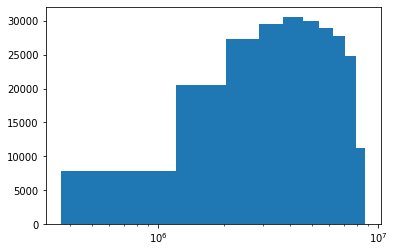

In [11]:
# electron fraction
xe = 0.01  # (Anders suggested it be in range 0.01 to 0.1)

# fill fraction
f_zone = 1.0 # (also suggested to be in range 0.01 to 0.1)

mp = aconst.m_p.cgs.value

t_epoch = 368.0 * u.d.to(u.s)

ne = xe * m_zone / 16 / mp / (4*np.pi/3 * (v_exp*t_epoch)**3 * f_zone)

plt.hist(ne);
plt.xscale('log');

(array([2.6000e+01, 2.8500e+02, 2.0040e+03, 8.2580e+03, 2.0530e+04,
        3.5201e+04, 4.3397e+04, 3.9792e+04, 2.9903e+04, 1.4915e+04]),
 array([9.41432323e+07, 1.00575884e+08, 1.07008537e+08, 1.13441189e+08,
        1.19873841e+08, 1.26306493e+08, 1.32739145e+08, 1.39171798e+08,
        1.45604450e+08, 1.52037102e+08, 1.58469754e+08]),
 <BarContainer object of 10 artists>)

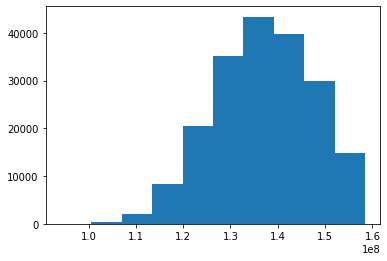

In [12]:
plt.hist(v_exp)

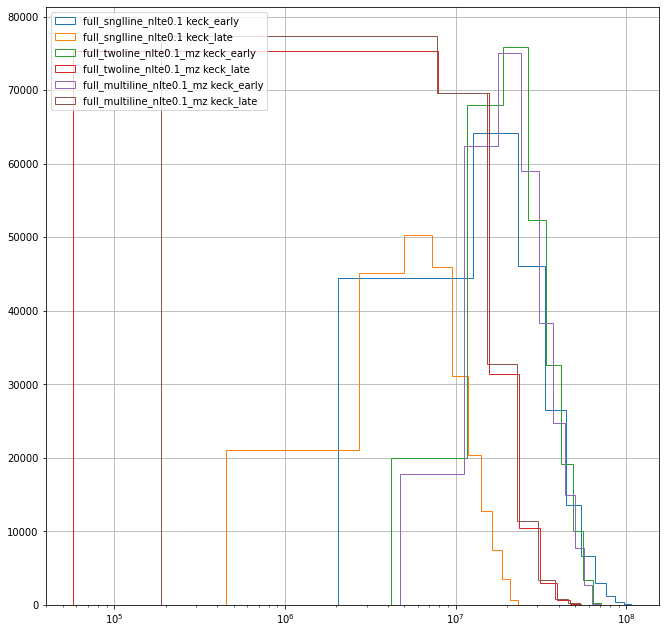

In [17]:
C = [
    ('keck_early', 'full_snglline_nlte0.1'),
    ('keck_late', 'full_snglline_nlte0.1'),
    ('keck_early', 'full_twoline_nlte0.1_mz'),
    ('keck_late', 'full_twoline_nlte0.1_mz'),
    ('keck_early', 'full_multiline_nlte0.1_mz'),
    ('keck_late', 'full_multiline_nlte0.1_mz')
]

plt.figure(figsize=(11,11))

for s_name, m_name in C:
    specmod = make_model(m_name, s_name)
    specmod.run()
    
    trace = specmod.samples

    # calculate line width
    KM_TO_CM = u.km.to(u.cm)
    v_exp = extract_model_line_velocity(specmod, np.ones(trace.shape[0], dtype=np.bool)) * KM_TO_CM

    # extract zone mass
    MSOL_TO_G = u.Msun.to(u.g)
    m_zone = trace[:,0] * MSOL_TO_G
    
    # electron fraction
    xe = 0.01  # (Anders suggested it be in range 0.01 to 0.1)

    # fill fraction
    #f_zone = 1.0 # (also suggested to be in range 0.01 to 0.1)
    f_zone = np.exp(np.random.uniform(-1, 0, size=trace.shape[0]))
    
    mp = aconst.m_p.cgs.value
    
    if s_name == 'not_late':
        t_epoch = 147 * u.d.to(u.s)
    elif s_name == 'keck_early':
        t_epoch = 157.7 * u.d.to(u.s)
    elif s_name == 'keck_late':
        t_epoch = 368.0 * u.d.to(u.s)

    ne = xe * m_zone / 16 / mp / (4*np.pi/3 * (v_exp*t_epoch)**3 * f_zone)

    plt.hist(ne, label=f'{m_name} {s_name}', histtype='step');
plt.xscale('log');
plt.legend()
plt.grid();